<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

# Test_Task_OOGa_Dooga

# Содержание проекта:
* [1. Работа с анализом eCPM по ОС.](#1-bullet)
* [2. Распределение средних eCPM по пользователям.](#2-bullet)
* [3. Рапределение средних eCPM по городам.](#3-bullet)
* [4. Суммарные показатели.](#4-bullet)
* [5. Суммарные показатели eCPM по городам.](#5-bullet)
* [6. По платформам.](#6-bullet)
* [7. Зависит ли что-то от времени ?](#7-bullet)
* [8. Какой тип рекламы самый эффективный ?](#8-bullet)
* [9. Вывод.](#8-bullet)



Приветствую каждого читающего данный Jupyter-Notebook! Желаю получить массу удовольствия от чистоты написанного здесь кода, от качества подбора инструментов визуализации и каждого слова в Markdown'е. А еще желаю, чтобы меня взяли на работу, ибо точно не прогадаете)) 

In [548]:
import pandas as pd
import numpy as np
import json
import time
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

Начнем с чтения данных. Тут все традиционно и понятно.

In [24]:
df = pd.read_csv('C:/Users/Iljam/Downloads/us events ad_revenue filtered 03.02-07.02.csv')

Из любопытного: датафрейм содержит столбец с json объектами, которые точно надо обработать.<br> А еще время задать вопрос - нет ли у нас лишних данных, и сколько у нас недостающих? 

In [25]:
df.head()

,profile_id,os_version,device_manufacturer,device_model,device_type,device_locale,event_name,event_json,event_datetime,event_timestamp,event_receive_datetime,event_receive_timestamp,connection_type,operator_name,country_iso_code,city
0,JLjpGzDHBQm,11,Samsung,Galaxy Tab S6,tablet,en_US,c_ad_revenue,"{""ad_type"":""banner"",""placement"":"""",""view_index...",2022-02-04 20:02:28,1643994148,2022-02-06 17:58:19,1644159499,wifi,NaN,US,Norwalk
1,JLjpGzDHBQm,11,Samsung,Galaxy Tab S6,tablet,en_US,c_ad_revenue,"{""ad_type"":""banner"",""placement"":"""",""view_index...",2022-02-04 20:02:45,1643994165,2022-02-06 17:58:19,1644159499,wifi,NaN,US,Norwalk
2,JLkVacrzHY6,11,Google,Pixel 2,phone,en_US,c_ad_revenue,"{""ad_type"":""banner"",""placement"":"""",""view_index...",2022-02-05 17:53:05,1644072785,2022-02-06 16:59:29,1644155969,wifi,Verizon,US,Charlotte
3,JMC6wG3cX0f,10,Samsung,Galaxy S9,phone,en_US,c_ad_revenue,"{""ad_type"":""int"",""placement"":""next_level"",""vie...",2022-02-06 17:09:01,1644156541,2022-02-06 17:09:24,1644156564,wifi,T-Mobile,US,Cocoa
4,JLzWWTJfi1b,10,Samsung,Galaxy S9,phone,en_US,c_ad_revenue,"{""ad_type"":""banner"",""placement"":"""",""view_index...",2022-02-06 17:15:38,1644156938,2022-02-06 17:16:16,1644156976,cell,Verizon,US,NaN


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 860079 entries, 0 to 860078
Data columns (total 16 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   profile_id               860065 non-null  object
 1   os_version               860079 non-null  object
 2   device_manufacturer      860079 non-null  object
 3   device_model             860079 non-null  object
 4   device_type              860079 non-null  object
 5   device_locale            860079 non-null  object
 6   event_name               860079 non-null  object
 7   event_json               860079 non-null  object
 8   event_datetime           860079 non-null  object
 9   event_timestamp          860079 non-null  int64 
 10  event_receive_datetime   860079 non-null  object
 11  event_receive_timestamp  860079 non-null  int64 
 12  connection_type          860079 non-null  object
 13  operator_name            841200 non-null  object
 14  country_iso_code    

In [27]:
df.describe()

,event_timestamp,event_receive_timestamp
count,8.600790e+05,8.600790e+05
mean,1.644088e+09,1.644088e+09
std,1.058604e+05,1.055928e+05
min,1.643467e+09,1.643836e+09
25%,1.644017e+09,1.644018e+09
50%,1.644102e+09,1.644103e+09
75%,1.644177e+09,1.644177e+09
max,1.644268e+09,1.644268e+09


Мобильная игра зарабатывает на показе рекламы. Есть несколько форматов:
int – полноэкранная реклама; banner – горизонтальный баннер, висит внизу
экрана пока юзер играет; rv – видео, которое юзер смотрит по желанию и за
просмотр получает монетки или др. ресурсы. Информация о каждом показе
отправляется в аналитику и содержит доход от показа, формат показанной
рекламы, рекламную сеть от которой был показ и др.
eCPM – доход за 1000 показов рекламы.

Столбец profile_id – id юзера
Столбец event_json содержит данные о событии показа рекламы:
ad_type – формат рекламы (int, banner или rv)
placement – когда/где был показ рекламы в игре
view_index – номер показа конкретного формата рекламы для юзера (не
поддерживается для баннеров)
revenue – доход от конкретного показа рекламы (eCPM = revenue * 1000)
ads_ltv – накапливающийся доход от рекламы, равен сумме всех revenue
юзера
network_name – рекламная сеть, от которой был показ
Остальные столбцы должны быть интуитивно понятны

Теперь настало время разобраться с json наполнением одного столбца.

In [46]:
result = json.loads(df.loc[100, 'event_json'])

In [47]:
result

{'ad_type': 'banner',
 'placement': '',
 'view_index': 1,
 'session_view_index': 0,
 'cur_ticks': 637797304162092540,
 'session_length': 1797.339,
 'revenue': 2.6212725e-05,
 'ads_ltv': 0.571129981369536,
 'ecpm_sma': 0.178478911519051,
 'normalized_ecpm_sma': 0.178478911519051,
 'value': 2.6212725e-05,
 'currency': 'USD',
 'ad_country_code': 'US',
 'network_name': 'APPLOVIN_EXCHANGE',
 'ad_unit_id': '64c6b1114ea8c1cc',
 'ad_network_placement': 'banner_regular',
 'creativeId': '211303'}

Посмотрели наполнение случайного json'а. Теперь мы знаем что внутри и как этого достичь. Осталось экстраполировать на оставшийся датафрейм

In [28]:
df_from_json = pd.DataFrame()
for num in range(10):
    for i in range(round(len(df)/10)):
        result = json.loads(df.loc[i + num * round(len(df) / 10), 'event_json'])
        df_dict = pd.DataFrame.from_dict(result, orient = 'index')
        df_dict = df_dict.T
        df_from_json = df_from_json.append(df_dict)
    display("df_from_JSON", len(df_from_json))
display("JOSN", df_from_json)      

Таким образом, мы получили датафрейм, который сделан из содержимого JSON'ов. Мы победили, но какой ценой...

Ремарка : так как данный ноутбук делался не за один раз, то я сохранил содержимое JSON в экселевском файле, чтобы не терять лишнего времени.

In [29]:
df_from_json = pd.read_excel('C:/Users/Iljam/Downloads/output.xlsx')

Теперь настало время рассчитать eCPM, несмотря на то, что есть столбец eCPM_SMA, который потенциально содержит фактические значения. Но надо бы и рассчитать по формуле и сравнить эти значения.

In [41]:
df_from_json['ecpm'] = df_from_json['revenue'] * 1000
df_from_json.head()

,Unnamed: 0,ad_type,placement,view_index,session_view_index,cur_ticks,session_length,revenue,ads_ltv,ecpm_sma,normalized_ecpm_sma,value,currency,ad_country_code,network_name,ad_unit_id,ad_network_placement,creativeId,ecpm
0,0,banner,NaN,1,0,637795729492245120,705.88070,0.000510,0.487877,0.511508,0.511508,0.000510,USD,US,Google AdMob,64c6b1114ea8c1cc,ca-app-pub-7511632782617496/8825263691,CJ3XirfD5vUCFYPnKAUdG3MOYQ,0.510313
1,0,banner,NaN,1,0,637795729659949824,722.65120,0.000510,0.488387,0.511389,0.511389,0.000510,USD,US,Google AdMob,64c6b1114ea8c1cc,ca-app-pub-7511632782617496/8825263691,CNa-lL_D5vUCFZrpKAUdU2QBDQ,0.510313
2,0,banner,NaN,1,0,637796515863735936,431.81290,0.002386,0.678479,0.928597,0.928597,0.002386,USD,US,APPLOVIN_EXCHANGE,64c6b1114ea8c1cc,banner_regular,pandora-58,2.386163
3,0,int,next_level,1,1,637797353426827392,125.94960,0.013894,0.013894,13.782633,13.893784,0.013894,USD,US,AppLovin,3ab7705b07ebb75f,inter_regular,13045364,13.893784
4,0,banner,NaN,1,0,637797357392197888,12.71129,0.006828,0.060571,1.660282,1.660282,0.006828,USD,US,Google AdMob,64c6b1114ea8c1cc,ca-app-pub-7511632782617496/6197324251,CMTi5e-h6_UCFUdVwQodt9EIMw,6.827570


Как и ожидалось, они не сошлись. Что это может значить, загадка .... 

Теперь надо совместить датафрейм из "Дано" и JSON.

In [69]:
df_total = df.join( df_from_json)

In [632]:
df_total['currency'].value_counts()

USD    121638
Name: currency, dtype: int64

In [637]:
df_total = df_total.drop('Unnamed: 0', axis = 1)

In [633]:
df_total = df_total.drop("currency", axis = 1)

Теперь переведем что нужно в разряд datetime

In [ ]:
df_total['event_datetime'] = pd.to_datetime(df_total['event_datetime'])

<a id='1-bullet'></a>

# Работа с анализом eCPM по ОС

В данном этапе будет рассмотрена зависимость eCPM по операционной системе.

Для начала сделаем сводную таблицу по распределению событий показа рекламы по версиям операционной системы:

In [525]:
pivot_os = df_total.pivot_table(index = "os_version",values = "profile_id", aggfunc = "count").sort_values(by = "profile_id", ascending = False)
pivot_os.columns  = ['count']
pivot_os

,count
os_version,
12,407587
11,209057
10,150871
9,66662
8.1.0,9249
8.0.0,8016
7.0,4057
7.1.2,1811
7.1.1,1342


По ней уже можно увидеть, на каких платформах в основном показывается реклама: превалируют 12, 11, 10 и 9 версии с большим отрывом.

Чтобы не быть голословным, проиллюстируем это с помощью графика: 

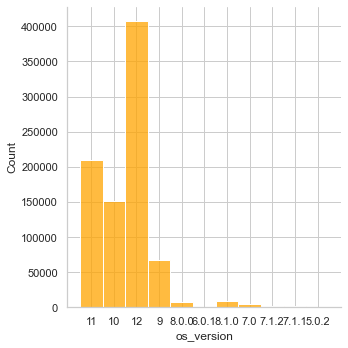

In [538]:
sns.displot(data=df_total, x="os_version", color = "orange", label =  "Распределение событий по различным ОС")

In [106]:
len(df_total.query('ecpm > 50'))

1729

<a id='2-bullet'></a>

# Распределение средних eCPM по пользователям

В данном этапе будут рассмотрены распределение средних показателей доходности от рекламы.

Надо понять типический показ рекламы : для этого надо понять в каких квартилях находится eCPM / пользователя. Для этого построим ящик с усами

(-0.5, 3.0)

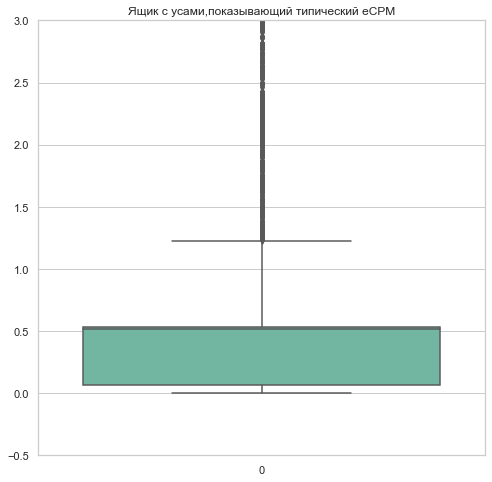

In [528]:
plt.figure(figsize = (8,8))
plt.title( "Ящик с усами,показывающий типический eCPM")
sns.boxplot(data = df_total['ecpm'], palette = "Set2")
plt.ylim(-0.5, 3)

Ну, и чтобы не быть голословным, надо рассчитать медиану, как одну из главных величин описательной статистики.

In [539]:
df_total['ecpm'].median()

0.513935

То есть, половина пользователей генерирует 0.51 у.е. за 1000 просмотров. По графику так же можно понять, что 75% квартиль находится в районе 1.25, что следует трактовать, по аналогии. 

Теперь следует рассмотреть под другим углом на данную метрику. Построим график распределения, представленный ниже :

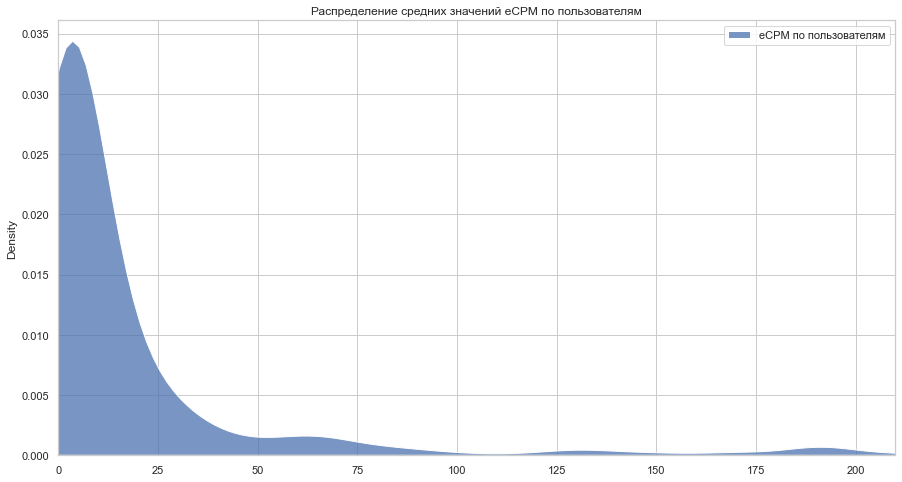

In [541]:
distplot_user = df_total.pivot_table(index = 'profile_id', values = 'ecpm', aggfunc = "mean")
plt.figure(figsize = (15,8))
plt.title("Распределение средних значений eCPM по пользователям")
sns.kdeplot(data = distplot_user, multiple="stack", label = "eCPM по пользователям")
plt.xlim(0,210)
plt.legend()

Можно сделать следующие выводы : случаи после 75 среднего eCPM следует рассматривать как статистические выбросы, которые конечно, крайне заманчиво выглядят для компании, которая размещает рекламу, но не стоит обольщаться смотря на некоторые цифры, так как в основной массе все выглядит несколько меньше.

<a id='3-bullet'></a>

#  Рапределение средних eCPM по городам

В данном этапе будет произведен анализ, который тоже внесет свою лепту в понимании типического пользователя и в то, что в теории можно попробовать сделать компании (так как это тестовое задание и я не посвящен во внутренние процессы, скажу, что эти предположения могут разбиваться о что-то, что я не учитываю как внешний пользователь данных, но берите на работу, и тогда решения, что предложу не будут столь поверхностны. Ох уж эти намеки ...

Для начала, следует по традиции сделать сводную таблицу по городам и средним eCPM. Традиции данной тетрадки в студию !

In [543]:
distplot_city = df_total.pivot_table(index = 'city', values = 'ecpm', aggfunc = "mean")
distplot_city.head()

,ecpm
city,
Abilene,191.400000
Afton,2.581332
Alamogordo,1.031599
Albuquerque,3.749385
Alexandria,1.121769


(0.0, 210.0)

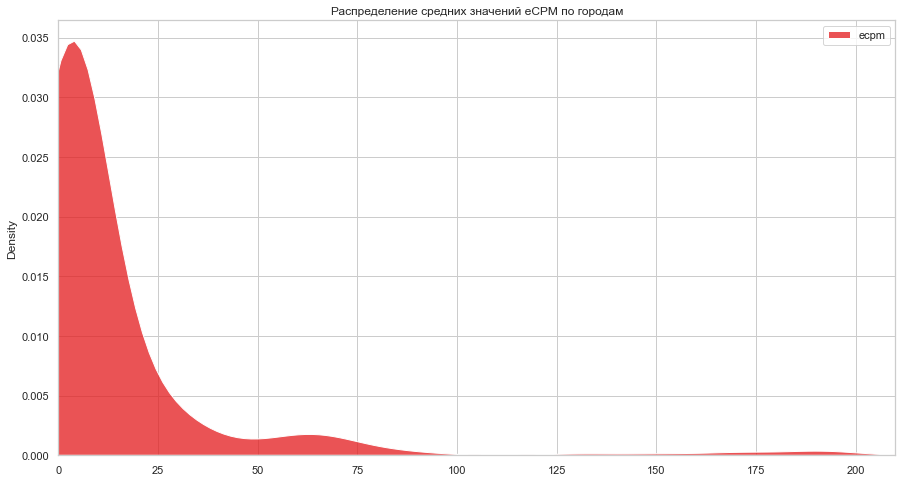

In [545]:
plt.figure(figsize = (15,8))
plt.title("Распределение средних значений eCPM по городам")
sns.kdeplot(data = distplot_city, multiple="stack", label = "eCPM по городам", palette  = "Set1")
plt.xlim(0,210)

Пока что в контексте ремарки о том, как я "великолепно" вывел данные и json файла, я буду делать выводы с соответствующими попущениями. И судя по графику, значени средних eCPM почти что идентичны значениям по пользователям, что говорит о том, что те же пользователи задествованы в этом анализе.

In [546]:
pivot_city = df_total.pivot_table(index = 'city',values = 'os_version', aggfunc = 'count').sort_values(by = 'os_version', ascending = False)

Соответственно, надо как-то по другому это преподнести и рассмотреть, чтобы сделать определенные выводы: 

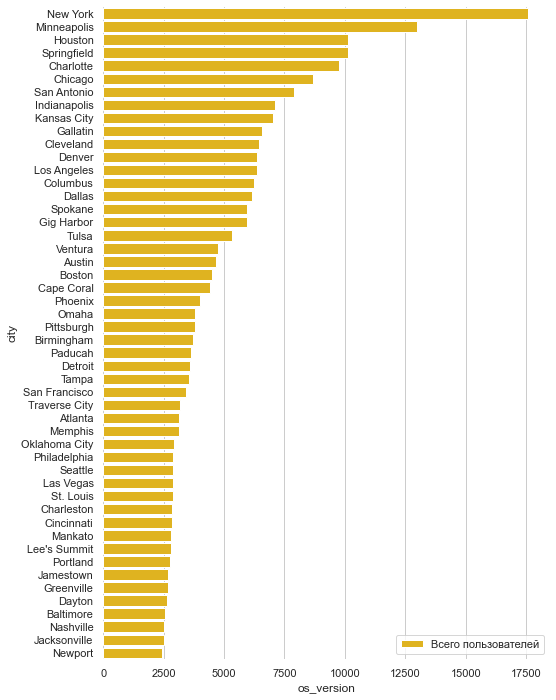

In [547]:
sns.set_theme(style="whitegrid")

f, ax = plt.subplots(figsize=(8, 12))
sns.set_color_codes("bright")
sns.barplot(x="os_version", y=pivot_city.sort_values(by = "os_version", ascending = False).head(50).index,
            data=pivot_city.sort_values(by = "os_version", ascending = False).head(50), label="Всего пользователей", color="y")

plt.legend(ncol=2, loc="lower right", frameon=True)
sns.despine(left=True, bottom=True)

по графику выше видно, какое у нас частота возникновения события рекламы : больше всего с огромным отрывом идет показ по Нью-Йорку, Миннеаполису и прочим, что видны на графике, который отображает топ-50 городов по данной метрике.

<a id='4-bullet'></a>

# Суммарные показатели

В данном этапе будут рассмотрены суммарные показатели по всем рассмотреным показателям выше. Посмотрим, какие выводы можно будет сделать.

<a id='5-bullet'></a>

# Суммарные показатели eCPM по городам

Начнем с городских показателей.

In [559]:
total_city = df_total.pivot_table(index = 'city',values = 'ecpm', aggfunc = 'sum').sort_values(by = 'ecpm', ascending = False)

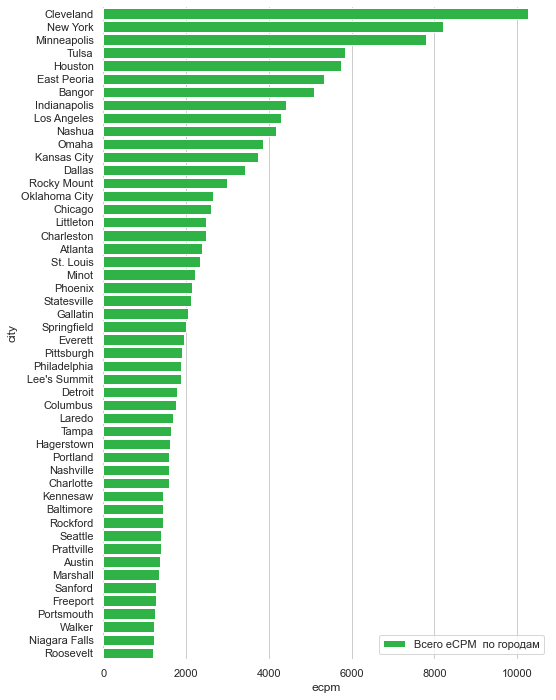

In [569]:
sns.set_theme(style="whitegrid")

f, ax = plt.subplots(figsize=(8, 12))
sns.set_color_codes("bright")
sns.barplot(x="ecpm", y=total_city.sort_values(by = "ecpm", ascending = False).head(50).index,
            data=total_city.sort_values(by = "ecpm", ascending = False).head(50), label="Всего eCPM  по городам", color="g")

plt.legend(ncol=2, loc="lower right", frameon=True)
sns.despine(left=True, bottom=True)

На удивление, не Нью-Йорк и Миннеаполис возглавляют данный топ-50, а Кливленд, который был на 11 месте, значит пользователи там, смотрят не много, но качественно. Над этим стоит подумать

<a id='6-bullet'></a>

# По платформам

In [572]:
sum_os = df_total.pivot_table(index = "os_version",values = "ecpm", aggfunc = "sum").sort_values(by = "ecpm", ascending = False)
sum_os.columns  = ['sum_ecpm']
sum_os

,sum_ecpm
os_version,
12,215249.239088
11,94437.377564
10,57749.053197
9,23408.112946
8.0.0,1985.354246
7.0,1573.130244
8.1.0,646.250692
7.1.1,610.934880
6.0.1,225.112002


<AxesSubplot:xlabel='os_version'>

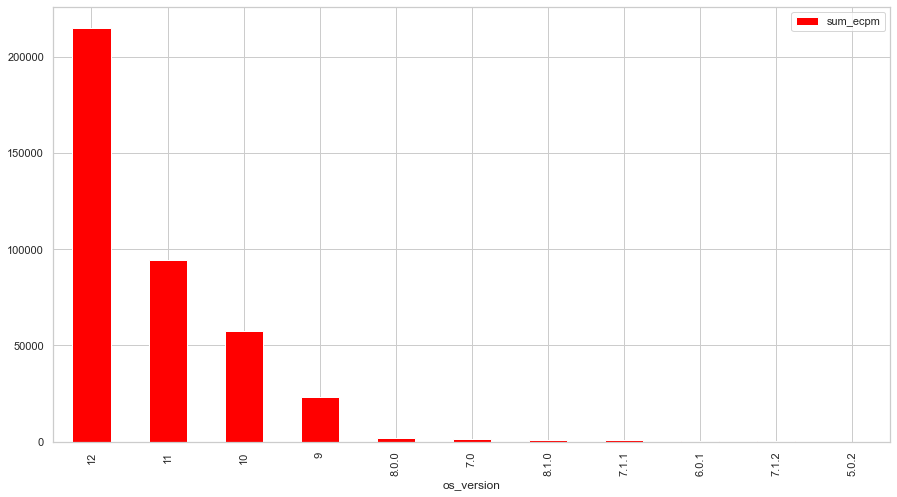

In [624]:
sum_os.plot(kind = "bar", figsize = (15,8), color = "red")

В целом, тут без сюрпризов, и те же платформы, что возглавляли топы до этого, продолжают это делать... Если бы были данные еще и в динамике для одних и тех же устройств, можно было бы понимать, какими темпами идет прогресс, и пользователи с более старыми платформами переходят на новые, и на основе этих данных понимать, насколько экономически эффективно а) размещать рекламу на устройства с такими параметрами б) насколько рентабельно оставлять в приложении поддержку старой версии ОС. Но это уже совсем другая история....

<a id='7-bullet'></a>

# Зависит ли что-то от времени ? 

На данном этапе мы посмотрим, зависит ли что-то от времени. Пользователи смотрят больше или меньше днем ? Когда выгоднее вкидывать рекламу? 

In [584]:
df_total['event_datetime']

0        2022-02-04 20:02:28
1        2022-02-04 20:02:45
2        2022-02-05 17:53:05
3        2022-02-06 17:09:01
4        2022-02-06 17:15:38
                 ...        
860074   2022-02-03 08:29:27
860075   2022-02-03 02:12:51
860076   2022-02-03 02:13:06
860077   2022-02-03 02:13:17
860078   2022-02-03 03:11:44
Name: event_datetime, Length: 860079, dtype: datetime64[ns]

In [590]:
for hour in range(len(df_total)):
    df_total.loc[hour, 'hour'] = df_total.loc[hour, 'event_datetime'].hour

Теперь будем анализировать зависимость eCPM от времени дня. Процесс будет выглядеть следующим образом : сначала я распределю на условные 4 группы - ночь - утро - день - вечер, потом посмотрим на группировки средних и суммарны eCPM? а там будет видно что и как.

In [587]:
df_total['event_datetime'] = pd.to_datetime(df_total['event_datetime'])

In [594]:
daypart = []
for i in range(len(df_total)):
    if df_total.loc[i , 'hour'] < 6:
        daypart.append("night")
    elif 6 < df_total.loc[i , 'hour'] < 12:
        daypart.append("morning")
    elif 12< df_total.loc[i , 'hour'] < 18 :
        daypart.append("day")
    else:
        daypart.append("evening")

In [595]:
df_total['part_of_day'] = daypart

In [596]:
pivot_day = df_total.pivot_table(index = 'part_of_day', values = 'ecpm', aggfunc = "mean")

<AxesSubplot:title={'center':'eCPM по времени дня'}, xlabel='part_of_day'>

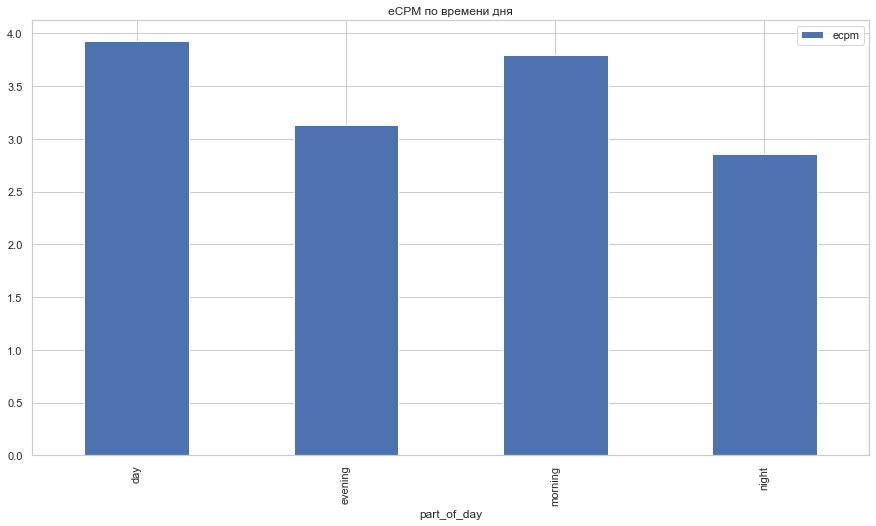

In [614]:
pivot_day.plot(kind = "bar", figsize = (15,8), title = "eCPM по времени дня", color = )

<a id='8-bullet'></a>

# Какой тип рекламы самый эффективный ? 

In [639]:
df_type_ad = df_total.pivot_table(index = "ad_type", values = 'ecpm', aggfunc = 'mean')
df_type_ad

,ecpm
ad_type,
banner,0.818187
int,41.260614
rv,73.353143


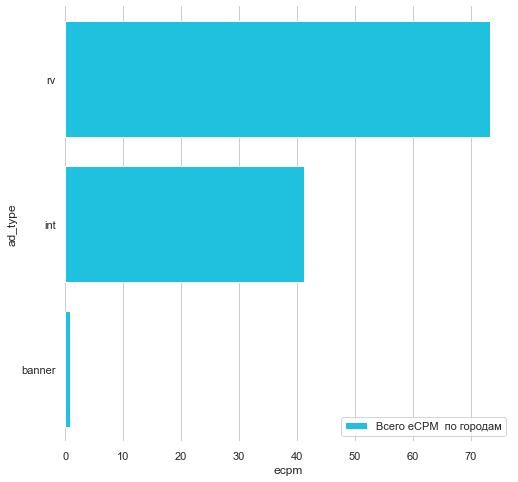

In [642]:
sns.set_theme(style="whitegrid")

f, ax = plt.subplots(figsize=(8, 8))
sns.set_color_codes("bright")
sns.barplot(x="ecpm", y=df_type_ad.sort_values(by = "ecpm", ascending = False).index,
            data=df_type_ad.sort_values(by = "ecpm", ascending = False), label="Всего eCPM  по городам", color="c")

plt.legend(ncol=2, loc="lower right", frameon=True)
sns.despine(left=True, bottom=True)

In [644]:
pivot_device = df_total.pivot_table(index = 'device_type', values = 'ecpm', aggfunc = "mean")
pivot_device

,ecpm
device_type,
phone,3.222194
tablet,4.269100


<AxesSubplot:xlabel='device_type'>

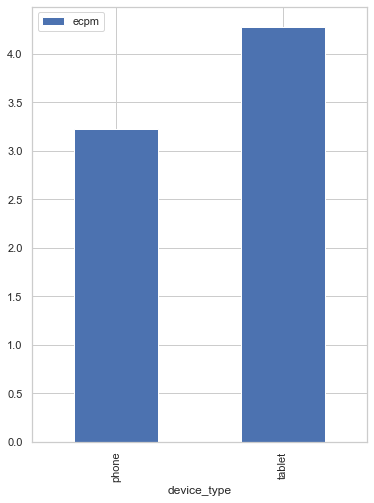

In [648]:
pivot_device.plot(kind = "bar", figsize = (6, 8))

Судя по всему, на средний планшет выгоднее размещать рекламу, чем на телефоны...

<AxesSubplot:xlabel='device_type'>

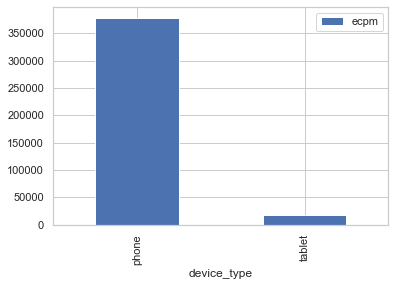

In [649]:
df_total.pivot_table(index = 'device_type', values = 'ecpm', aggfunc = "sum").plot(kind = "bar")

Но, как и ожидалось, телефонов все-таки больше....

<a id='9-bullet'></a>

# Вывод

По работе можно сделать следующие выводы : <br>
1) Типический пользователь (то есть который количественно чаще встречается) характеризуется как сидящий на 12 ОС, из Нью-Йорка<br>
2) Пользователь, приносящий больше всего денег - из Кливленда, тоже смотрящий рекламу на 12 ос

Предлагаемые варианты для развития проекта : 
<font color='green'>
1) Акцентировать внимание на развитии приложений под свежие операционные системы, так как переходящих туда пользователей количественно и качественно больше <br>
2) Сохранить аудиторию из Нью-Йорка как самую часто потребляющую рекламу посредством возможно её увеличения (возможно с помощью увеличения временной составляющей рекламы, или легонько поднять ее частоту НО ЭТО ГИПОТЕЗЫ КОТОРЫЕ НАДО ПОДТВЕРЖДАТЬ ЭКСПЕРИМЕНТАЛЬНЫМИ ДАННЫМИ НАПРИМЕР С ПОМОЩЬЮ AB ТЕСТИРОВАНИЯ. ЯВЛЯЕТСЯ ПОВЕРХНОСТНОЙ РЕКОМЕНДАЦИЕЙ НА ОСНОВЕ ОГРАНИЧЕННОЙ ИНФОРМАЦИИ<br>
3) Предлагать рекламодателям регион Кливленда, Нью-Йорка и прочих из вышепоказанного топа как приоритетные и рекомендованные регионы для показа рекламы.<br>
4) С 0 до 12 пользователи больше склонны приносить денег, смотря рекламу. Возможно, в соответствии с этой гипотезой стоит разрабатывать алгоритмы, подсовывающие рекламу.<br>
5) Видео и полноэкранная реклама - самые приносящие в среднем форматы рекламы.<br>
6) Размещать рекламные объявления судя по всему выгоднее на телефоны, ибо их банально больше.

Чего избегать : <br>
<font color='red'>
1) Базово, потери "лояльности" аудитории из Кливленда как самой лояльной к рекламе.<br>
2) Стараться не выставлять рекламу с 12 до 0. Точнее, делать это иначе, потому что в это время идет меньший рекламный поток.<br>
3)Баннеры - экономически неэффективны в том виде, в каком они есть у рекламодателей. Надо что-то с этим делать.
4) Развивать рекламу, рассчитанную под планшеты, ее меньше смотрят из-за специфики устройства и не такой распространенности, как телефонов.